<a href="https://colab.research.google.com/github/Madhusudhanbandi/EVA4-S12/blob/master/EVA_S12_ASSIG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd '/content/gdrive/My Drive/Colab Notebooks'


/content/gdrive/My Drive/Colab Notebooks


In [4]:
!pip install torchvision
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary
from myfunctions import *
from models import *
from Grad_Cam import get_last_conv,Grad_Cam
from transforms_dataloading import *
from tqdm import tqdm
from model_s12 import *
from tinyimagenet import *
from utils import *
import cv2

import numpy as np



In [0]:
import os
import zipfile
import requests
from io import StringIO,BytesIO

def download_images(url):
  if (os.path.isdir('tiny-imagenet-200.zip')):
    print('Images already downloaded')
    return 
  r = requests.get(url,stream=True)
  print("Downloading..." + url)
  zip_ref =zipfile.ZipFile(BytesIO(r.content))
  zip_ref.extractall('./')
  zip_ref.close()

download_images("http://cs231n.stanford.edu/tiny-imagenet-200.zip")


Downloading...http://cs231n.stanford.edu/tiny-imagenet-200.zip


In [0]:
segregate()

**Downloading datasets and applying transforms**

In [0]:
transform = transforms.Compose(
[transforms.ToTensor(),
 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_dataset= datasets.ImageFolder(root="/content/gdrive/My Drive/Colab Notebooks/MergeData/Train",transform=transform)

test_dataset= datasets.ImageFolder(root="/content/gdrive/My Drive/Colab Notebooks/MergeData/Val",transform=transform)

In [13]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 77000
    Root location: /content/gdrive/My Drive/Colab Notebooks/MergeData/Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [14]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 33000
    Root location: /content/gdrive/My Drive/Colab Notebooks/MergeData/Val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

**Loading data to train and test loader**

In [15]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(111)

if cuda:
    torch.cuda.manual_seed(111)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,num_workers=4)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

CUDA Available? True


In [14]:
len(trainloader)

602

**Visualizing**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

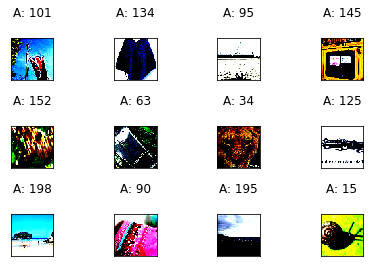

In [16]:
import matplotlib.pyplot as plt
dataiter = iter(trainloader)
images,lables = next(dataiter)

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(((images[i]).permute(1,2,0).numpy().squeeze()), interpolation='none')
  plt.title('A: {}\n'.format(lables[i]))

  plt.xticks([])
  plt.yticks([])

**Building model network**

In [7]:
Net=own_resnet_model()

Model was build as per given architucture....


**Adding model to device**

In [8]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model,input_size=(3,64,64))
print("Model added to device")

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,728
         MaxPool2d-5          [-1, 128, 32, 32]               0
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,456
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,456
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
           Conv2d-14          [-1,

**Traing network with SGD and OneCycleLR schedular**

In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR


train_los=[]
train_acs=[]
test_los=[]
test_acs=[]
lr_data=[]

L2lambda=0
ep=len(trainloader)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True, weight_decay=L2lambda)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, epochs=50,steps_per_epoch=ep,pct_start=0.2)
  

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    
    train_losses,train_acces=training_model_with_scheduler(model, device, trainloader, optimizer,scheduler,criterion)
    train_acs.append(train_acces)
    test_losses, test_acces=testing_model(model, device, testloader)
    test_acs.append(test_acces)

  0%|          | 0/602 [00:00<?, ?it/s]

EPOCH: 1
LR used in this epoch is: 0.006342324519632014

Train set: Average loss: 36.5231, Train Accuracy: (10.99%)




  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 9.5518, Test Accuracy: 5714/33000 (17.32%)

EPOCH: 2
LR used in this epoch is: 0.013155406837874181

Train set: Average loss: 28.5341, Train Accuracy: (24.49%)





  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 8.3434, Test Accuracy: 8503/33000 (25.77%)

EPOCH: 3
LR used in this epoch is: 0.023772121731852627

Train set: Average loss: 24.8582, Train Accuracy: (32.05%)






  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 7.8103, Test Accuracy: 9574/33000 (29.01%)

EPOCH: 4
LR used in this epoch is: 0.037152888674890236

Train set: Average loss: 21.6843, Train Accuracy: (39.10%)







  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 7.0099, Test Accuracy: 11673/33000 (35.37%)

EPOCH: 5
LR used in this epoch is: 0.05198747329741978

Train set: Average loss: 18.6419, Train Accuracy: (45.97%)








  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 6.6287, Test Accuracy: 12660/33000 (38.36%)

EPOCH: 6
LR used in this epoch is: 0.06682328452499581

Train set: Average loss: 15.9727, Train Accuracy: (52.66%)









  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 6.1872, Test Accuracy: 13802/33000 (41.82%)

EPOCH: 7
LR used in this epoch is: 0.08020761117495358

Train set: Average loss: 13.4609, Train Accuracy: (59.10%)










  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 6.4293, Test Accuracy: 13950/33000 (42.27%)

EPOCH: 8
LR used in this epoch is: 0.09082987031397219

Train set: Average loss: 10.8937, Train Accuracy: (65.78%)



  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 6.3565, Test Accuracy: 14421/33000 (43.70%)

EPOCH: 9
LR used in this epoch is: 0.09764993852718022

Train set: Average loss: 8.1614, Train Accuracy: (73.46%)












  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 6.5975, Test Accuracy: 14561/33000 (44.12%)

EPOCH: 10
LR used in this epoch is: 0.1

Train set: Average loss: 5.4636, Train Accuracy: (81.32%)













  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 7.6469, Test Accuracy: 13718/33000 (41.57%)

EPOCH: 11
LR used in this epoch is: 0.09984586730318966

Train set: Average loss: 3.3025, Train Accuracy: (88.32%)














  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 7.5006, Test Accuracy: 14461/33000 (43.82%)

EPOCH: 12
LR used in this epoch is: 0.09938441949208877

Train set: Average loss: 1.8161, Train Accuracy: (93.51%)















  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 8.2116, Test Accuracy: 15028/33000 (45.54%)

EPOCH: 13
LR used in this epoch is: 0.09861850154589975

Train set: Average loss: 0.9622, Train Accuracy: (96.73%)
















  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 8.1503, Test Accuracy: 15500/33000 (46.97%)

EPOCH: 14
LR used in this epoch is: 0.09755283560345443

Train set: Average loss: 0.4145, Train Accuracy: (98.81%)

















  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 8.3088, Test Accuracy: 15782/33000 (47.82%)

EPOCH: 15
LR used in this epoch is: 0.09619399184965784

Train set: Average loss: 0.1431, Train Accuracy: (99.76%)


















  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 7.8526, Test Accuracy: 16453/33000 (49.86%)

EPOCH: 16
LR used in this epoch is: 0.09455034800811356

Train set: Average loss: 0.0542, Train Accuracy: (99.95%)



















  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 7.7688, Test Accuracy: 16730/33000 (50.70%)

EPOCH: 17
LR used in this epoch is: 0.09263203768967174

Train set: Average loss: 0.0346, Train Accuracy: (99.97%)




















  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 7.7069, Test Accuracy: 16891/33000 (51.18%)

EPOCH: 18
LR used in this epoch is: 0.0904508879153485

Train set: Average loss: 0.0356, Train Accuracy: (99.97%)





















  0%|          | 0/602 [00:00<?, ?it/s]


Test set: Average Loss: 7.7154, Test Accuracy: 16912/33000 (51.25%)

EPOCH: 19
LR used in this epoch is: 0.08802034619880844

Train set: Average loss: 0.0312, Train Accuracy: (99.97%)

